In [3]:
%cd "~/lab/NB10422645"

# from ._base import SurrogateModelBaseRegression
from src.surrogate.meta_models.deeplearning import Trainer3
import torch.nn as nn
import torch
from src.surrogate.meta_models.modules import activation_dict
from src.surrogate.meta_models.modules.fx import RegressionOutput, BasicBlock
from src.dataset import DataSetFX
from src.surrogate.meta_models.deeplearning.util import LutzPrecheltEarlyStopping
import skopt


from torch import nn
class SimpleRectangularNN(nn.Module):

    def __init__(self, model_params):
        Xdim = model_params["x_dim"]
        fdim = model_params["f_dim"]
        activation = model_params["activation"]
        dropout_rate = model_params["dropout_rate"]
        n_hidden_layers = model_params["n_hidden_layers"]
        n_hidden_neurons = model_params["n_hidden_neurons"]
        super().__init__()
        self.fc_in = nn.Sequential(
            *[nn.Linear(Xdim, n_hidden_neurons),
              activation_dict[activation],
              nn.Dropout(dropout_rate),
              nn.BatchNorm1d(n_hidden_neurons)]
        )
        self.fc_center = nn.Sequential(
            *[nn.Linear(n_hidden_neurons, n_hidden_neurons),
              activation_dict[activation],
              nn.Dropout(dropout_rate),
              nn.BatchNorm1d(n_hidden_neurons)
              ] * int(n_hidden_layers - 2)
        )
        self.fc_out = RegressionOutput(n_hidden_neurons, fdim)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.fc_center(x)
        return self.fc_out(x)

/home/ggarrett/lab/NB10422645


In [61]:
import skopt
from src.utils import TQDMSkoptCallable


decision_space = [
    
    # Architecture params.
#     skopt.space.Categorical(["sigmoid", "relu", "leaky_relu"], name="activation"),
    skopt.space.Integer(1,5        ,                           name="n_hidden_layers"),
#     skopt.space.Real(*(5e-3, 5e-1),                            name="dropout_rate"),
    skopt.space.Integer(200, 900,                              name="n_hidden_neurons"),
    
#     # Training parameters.
#     skopt.space.Integer(0,2,             name="early_stopping"),
#     skopt.space.Real(0.1,4,             name="early_stopping_alpha"),
    
    skopt.space.Integer(500, 5000,                               name="num_epochs"),
#     skopt.space.Integer(50, 500,                               name="batch_size"),
    
#     skopt.space.Real(1e-5, 1e-1, prior="log-uniform",          name="learning_rate")
#     "num_epochs":2000,
]

early_stop_list = [
        LutzPrecheltEarlyStopping(5, criteria=(("PQ", 0.75),)),
        LutzPrecheltEarlyStopping(5, criteria=(("PQ", 1.00),)),
        LutzPrecheltEarlyStopping(5, criteria=(("PQ", 1.50),))
    
    
    ]

# 0 n_hidden_layers           1
# 1 dropout_rate              0.005
# 2 n_hidden_neurons          900
# 3 batch_size                500
# 4 batch_size                500
# 5 learning_rate             0.0001
# 0.00065865513170138

# 0 n_hidden_layers           3
# 1 dropout_rate              0.2041191596735072
# 2 n_hidden_neurons          245
# 3 learning_rate             0.00021990548087642936
# 0.0001707093178993091

# 0 n_hidden_layers           3
# 1 n_hidden_neurons          530
# 2 learning_rate             0.0004533057311401965
# 0.0004141229437664151

# 0 activation                leaky_relu
# 1 dropout_rate              0.10554329652319022
# 2 batch_size                67
# 3 learning_rate             0.0003558890790839316
# 0.00045175422565080225

# 0 n_hidden_neurons          200
# 1 learning_rate             0.001018101599607729

# 0 n_hidden_layers           3
# 1 dropout_rate              0.034776364339932836
# 2 n_hidden_neurons          204
# 3 early_stopping            0
# 4 learning_rate             0.00016933904689653333

static_params = {

    # Architecture parameters.
    "activation":"leaky_relu",
    "n_hidden_layers":3,
    "n_hidden_neurons":200,
    "dropout_rate":0.2041191596735072,
    
    # Training parameters.
    "early_stopping_alpha":4,
    "batch_size":500,
    "learning_rate":0.00021990548087642936,
    "num_epochs":2000,
    
}

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu")

print(device)

def t2n(t):
    return t.detach().cpu().numpy()
    
def Xn2t(X):
    return torch.tensor(X).to(device).float()

def Fn2t(f):
    return torch.tensor(f.reshape(-1, 1)).to(device).float()


cuda


In [53]:
from scipy.io import loadmat

train = loadmat("simulation/data/rs_bicycle/idoe/rs_bicycle_UG_N3_S15.mat") 
test = loadmat("simulation/data/rs_bicycle/idoe/rs_bicycle_UG_N3_S10.mat")
x_train = train["X"]
y_train = train["F"][:,1]

x_test = test["X"]
y_test = test["F"][:,1]

# Dataset.
training_dataset = DataSetFX(
        output=y_train.reshape(-1, 1),
        input=x_train.reshape(-1, len(x_train.T)))
validation_dataset = DataSetFX(
        output=y_test.reshape(-1, 1),
        input=x_test.reshape(-1, len(x_train.T)))

In [ ]:

@skopt.utils.use_named_args(decision_space)
def objective(**decided_params):
        
    # Load parameters.
    params = {**static_params, **decided_params}
    
    # Create model.
    model_params={}
    model_params["x_dim"] = 3
    model_params["f_dim"] = 1
    model_params["activation"] = params["activation"]
    model_params["dropout_rate"] = params["dropout_rate"]
    model_params["n_hidden_layers"] = params["n_hidden_layers"]
    model_params["n_hidden_neurons"] = params["n_hidden_neurons"]
    model = SimpleRectangularNN(model_params)
    
    # Training params.
#     early_stopping = params["early_stopping"]
    learning_rate  = params["learning_rate"]
    batch_size     = params["batch_size"]
    
    # Set up trainer.
    trainer = Trainer3(
        PATH="meta_models/",
        training_dataset=training_dataset,
        validation_dataset=validation_dataset,
        model=model,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.modules.loss.MSELoss,
        batch_size=int(batch_size),
        num_epochs=params["num_epochs"],
        learning_rate=params["learning_rate"])
    
    trainer.train(early_stopping=LutzPrecheltEarlyStopping(5, criteria=(("PQ", params["early_stopping_alpha"]),)),
                    save_each_epoch=False,
                    save_final_model=False,
                    plot_jupyter=False,
                    verbose=False)
    
    model.eval()
    with torch.no_grad():
        res=trainer._criterion(
                model(Xn2t(validation_dataset.input)),
                Fn2t(validation_dataset.output)).detach().cpu().numpy()
#         res = model(validation_dataset.input)
    return float(res)

n_calls=50

progress = TQDMSkoptCallable(total=n_calls, desc="Model HpOpt",
                             leave=False)

def plotcha(results):
    skopt.plots.plot_evaluations(results)
    plt.show()
    skopt.plots.plot_convergence(results)
    plt.show()
    
callback = [progress, plotcha]

results=skopt.gp_minimize(objective, decision_space, n_calls=n_calls, callback=callback)
# print(results)

In [96]:
from src.surrogate.test import TestFunctionSet2DInputSpace as F2D
from src.surrogate.test import TestFunctionSetNDInputSpace as FND
from sklearn.preprocessing import MinMaxScaler
from src.utils import TQDMSkoptCallable

n_calls=100
dim=4

F=FND(dim)[1]
progress2 = TQDMSkoptCallable(total=n_calls, desc="Model HpOpt", leave=False)
decision_space2 = [skopt.space.Real(0,1,name=f"x{i}") for i in range(dim)]

@skopt.utils.use_named_args(decision_space2)
def objective2(**decided_params):
    return F(*[decided_params[f"x{i}"] for i in range(dim)])

results2=skopt.gp_minimize(objective2, decision_space2, n_calls=n_calls, callback=[progress2])

Sphere function [4D]


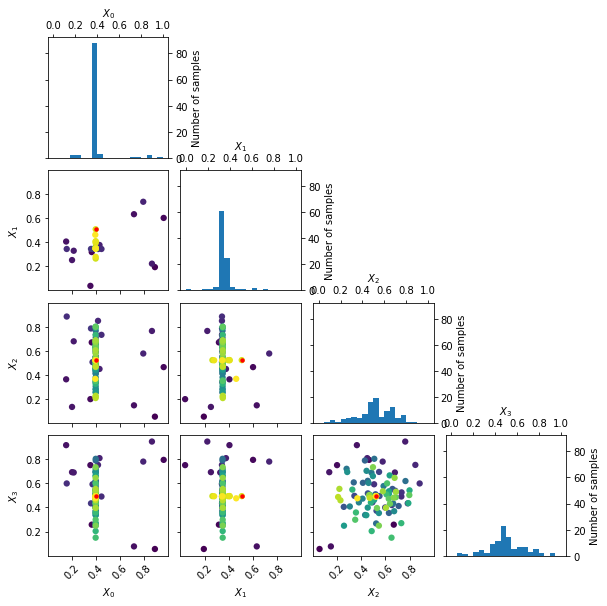

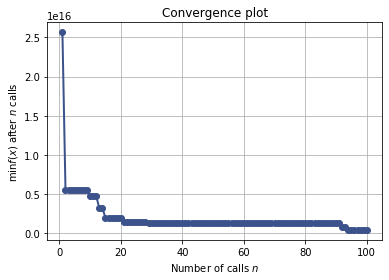

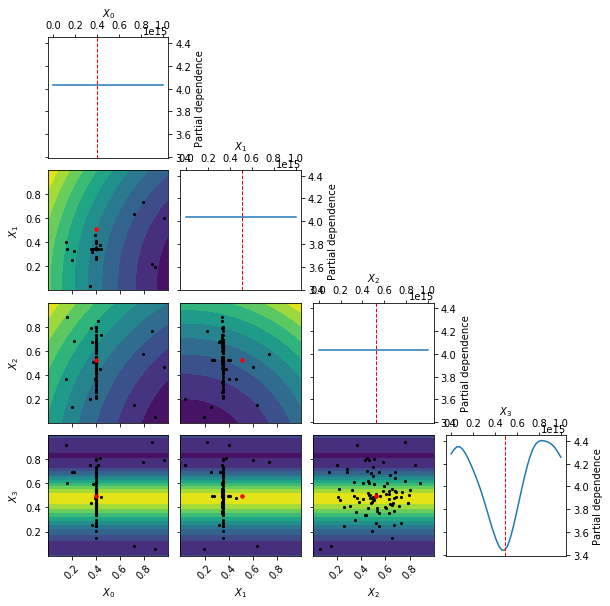

[0.3964599656678191, 0.50792221415377, 0.5222332318446518, 0.4941262603381016]
Sphere function [4D]


In [97]:
import skopt.plots
import matplotlib.pyplot as plt

print(F)
skopt.plots.plot_evaluations(results2)
plt.show()
skopt.plots.plot_convergence(results2)
plt.show()
skopt.plots.plot_objective(results2)
plt.show()
print(results2.x)
print(F)

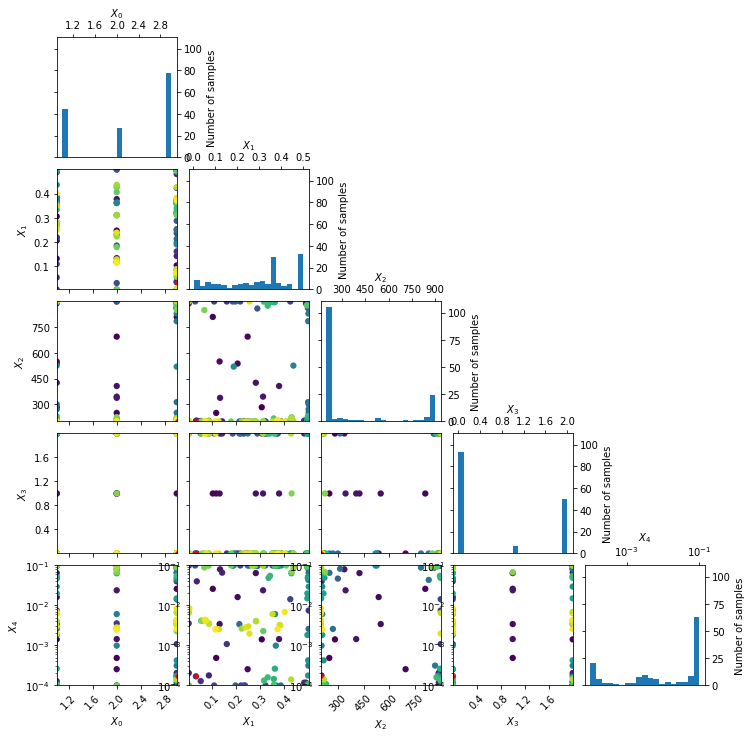

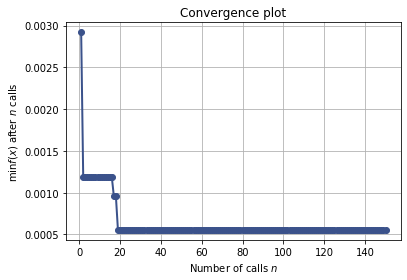

In [9]:
# print(results)
# from src.utils import plot_evaluations
import skopt.plots
import matplotlib.pyplot as plt

skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()

In [20]:
for idx, i in enumerate(decision_space):
    print(idx, i.name.ljust(25), results.x[idx])

0 n_hidden_neurons          200
1 learning_rate             0.001018101599607729


In [21]:
print(results.fun)

0.0005627739592455328


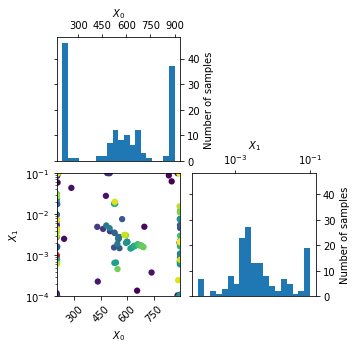

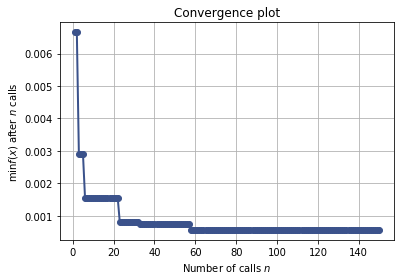

In [19]:
# print(results)
# from src.utils import plot_evaluations
import skopt.plots
import matplotlib.pyplot as plt

skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()

0 activation                leaky_relu
1 dropout_rate              0.10554329652319022
2 batch_size                67
3 learning_rate             0.0003558890790839316
0.00045175422565080225


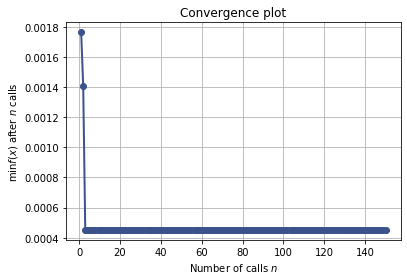

In [31]:
for idx, i in enumerate(decision_space):
    print(idx, i.name.ljust(25), results.x[idx])
# print(results)
# from src.utils import plot_evaluations
print(results.fun)
import skopt.plots
import matplotlib.pyplot as plt

# skopt.plots.plot_evaluations(results)
# plt.show()
skopt.plots.plot_convergence(results)
plt.show()
# print(results)
# skopt.plots.plot_objective(results)
# plt.show()


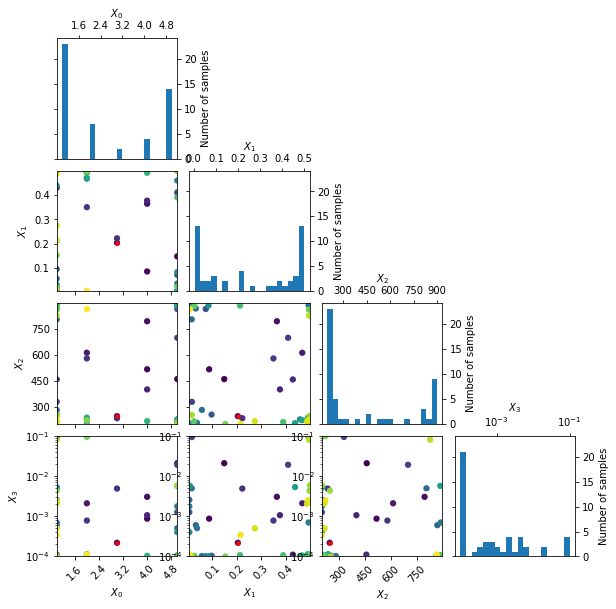

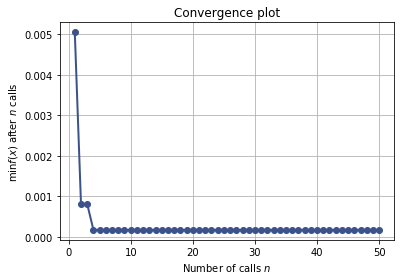

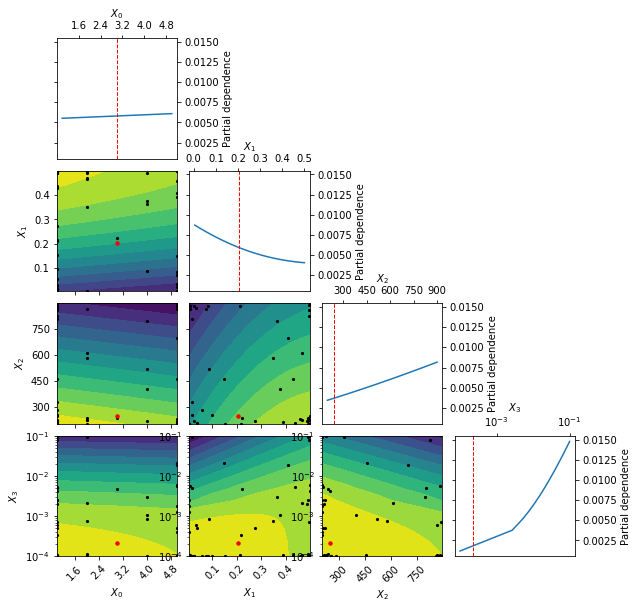

0 n_hidden_layers           3
1 dropout_rate              0.2041191596735072
2 n_hidden_neurons          245
3 learning_rate             0.00021990548087642936
0.0001707093178993091


In [51]:

# print(results)
# from src.utils import plot_evaluations

import skopt.plots
import matplotlib.pyplot as plt

skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()
# print(results)
skopt.plots.plot_objective(results)
plt.show()

for idx, i in enumerate(decision_space):50
    print(idx, i.name.ljust(25), results.x[idx])
print(results.fun)

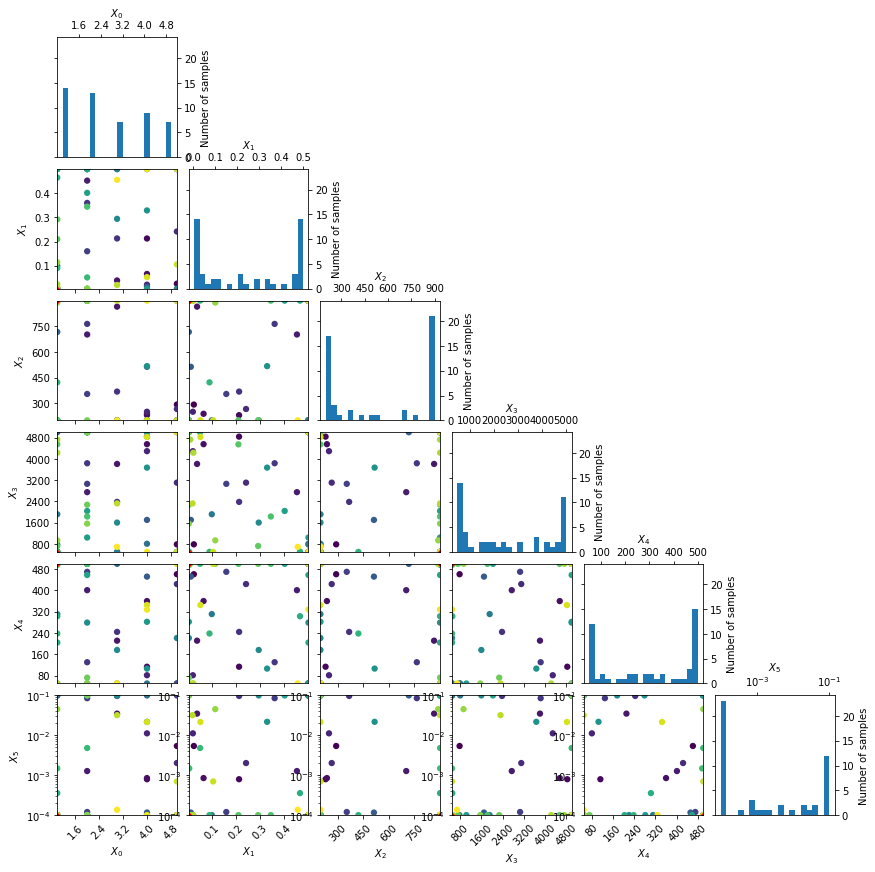

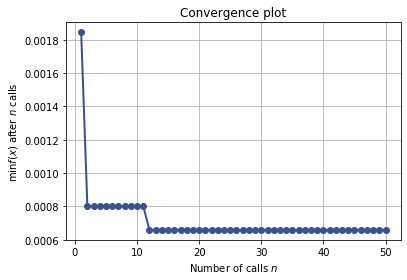

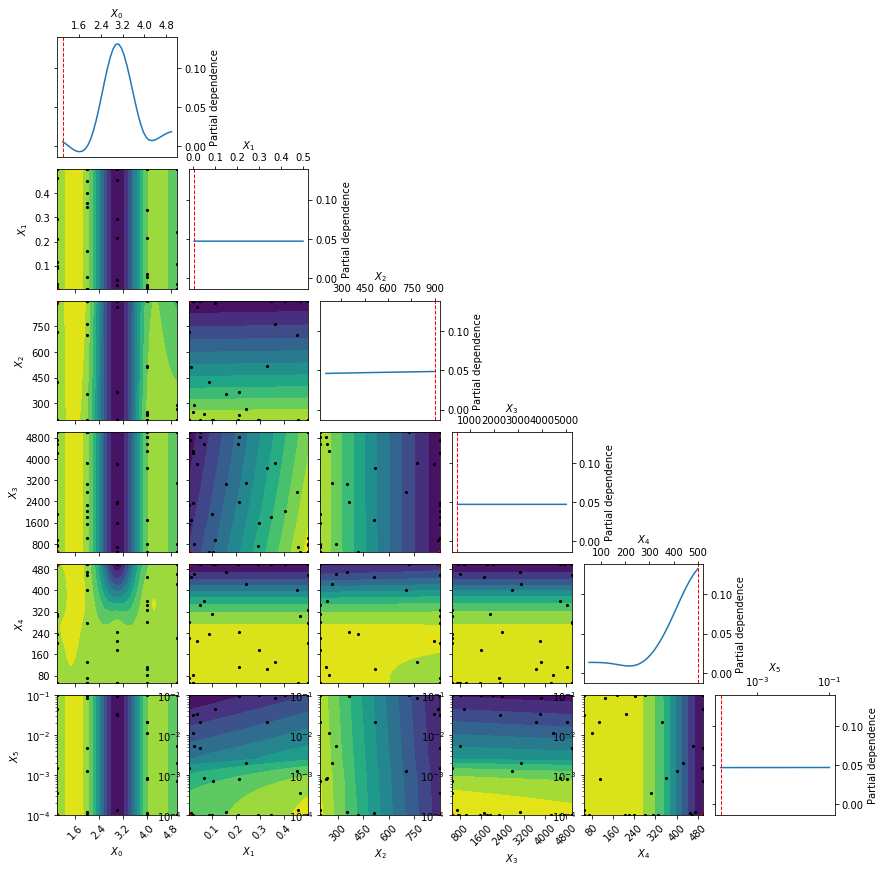

0 n_hidden_layers           1
1 dropout_rate              0.005
2 n_hidden_neurons          900
3 batch_size                500
4 batch_size                500
5 learning_rate             0.0001
0.00065865513170138


In [56]:

# print(results)
# from src.utils import plot_evaluations

import skopt.plots
import matplotlib.pyplot as plt

skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()
# print(results)
skopt.plots.plot_objective(results)
plt.show()

for idx, i in enumerate(decision_space):
    print(idx, i.name.ljust(25), results.x[idx])
print(results.fun)

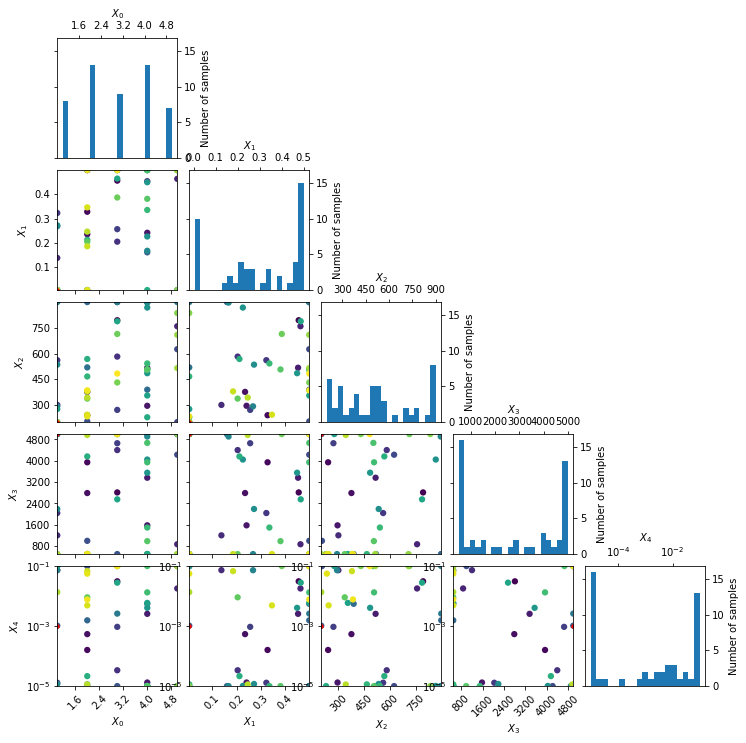

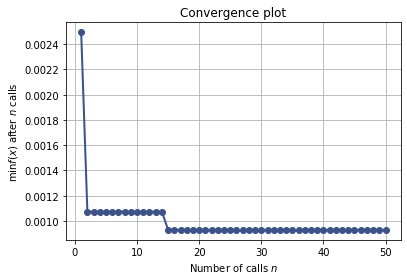

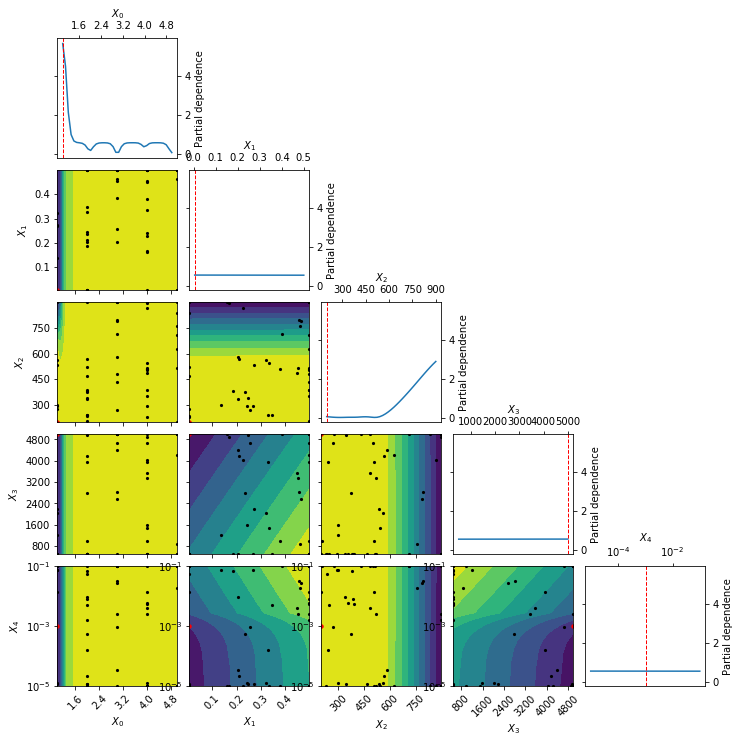

0 n_hidden_layers           1
1 dropout_rate              0.005
2 n_hidden_neurons          200
3 num_epochs                5000
4 learning_rate             0.0010311444839982452
0.0009296097559854388


In [59]:

# print(results)
# from src.utils import plot_evaluations

import skopt.plots
import matplotlib.pyplot as plt

skopt.plots.plot_evaluations(results)
plt.show()
skopt.plots.plot_convergence(results)
plt.show()
# print(results)
skopt.plots.plot_objective(results)
plt.show()

for idx, i in enumerate(decision_space):
    print(idx, i.name.ljust(25), results.x[idx])
print(results.fun)